# Vision Transformer (ViT)

reference 
- https://arxiv.org/pdf/2010.11929.pdf
- https://www.kaggle.com/abhinand05/vision-transformer-vit-tutorial-baseline

architecture
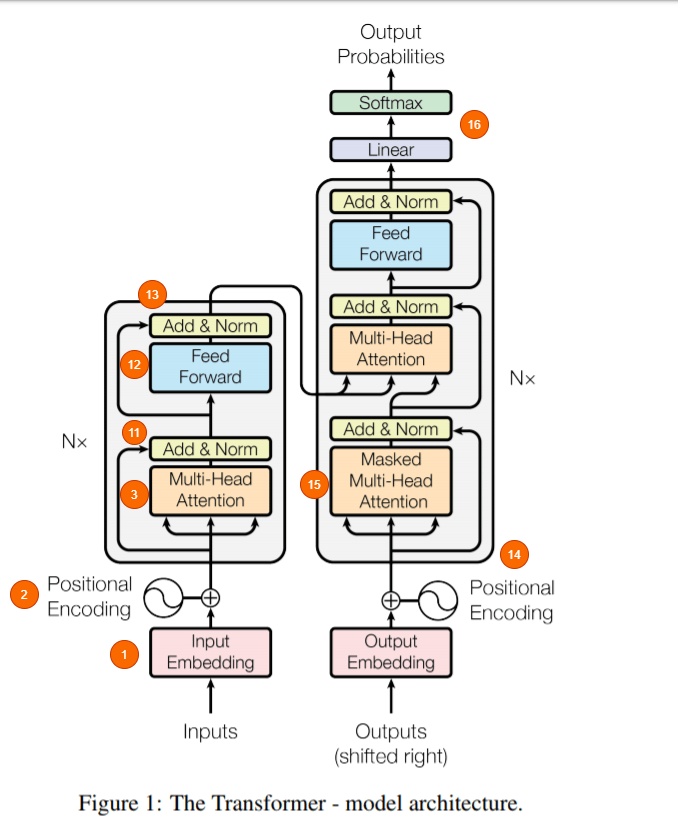
- has two parts : the decoder which is on left side, the encoder which is on the right.